# Get Started With Transfer Learning Example
This example shows how to fine-tune a pretrained GoogleNet network to classify a new collection of images. This process is called transfer learning and is usually much faster and easier than training a new network, because you can apply learned features to a new task using a smaller number of training images. 

Before starting, please ensure that you have downloaded the MerchData.zip, and MerchDataTest.jpg files from canvas 

Note: This script uses some commands that work fine on google colab but are linux native commands and thus may not work for you. They are all commands that are moving files around and thus if they don't work, please either make the file adjustments manually or run the code locally. You might need to wait for 
colab to finish IO operation before proceeding to next cell

In [ ]:
#You can use a gpu to speed up training time. In colab go to runtime > "Change runtime type" > and select gpu
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Extract Data for training
First we have to collect and unpack our dataset. This command unzips the training data and creates a new train directory. 

In [1]:
# from google.colab import drive
import os
import shutil 
# drive.mount('/content/drive')
!unzip "MerchData.zip" -d "./"

# feel free to edit this cell to work with your local or colab directory
WORKING_DIR = '.'
TRAIN_DIR = './train'
VAL_DIR = './val'

shutil.move(os.path.join(WORKING_DIR,'MerchData','MathWorks Cap'), os.path.join(TRAIN_DIR, 'Cap'))
shutil.move(os.path.join(WORKING_DIR,'MerchData','MathWorks Cube'), os.path.join(TRAIN_DIR, 'Cube'))
shutil.move(os.path.join(WORKING_DIR,'MerchData','MathWorks Playing Cards'), os.path.join(TRAIN_DIR, 'PlayingCard'))
shutil.move(os.path.join(WORKING_DIR,'MerchData','MathWorks Screwdriver'), os.path.join(TRAIN_DIR, 'Screwdriver'))
shutil.move(os.path.join(WORKING_DIR,'MerchData','MathWorks Torch'), os.path.join(TRAIN_DIR, 'Torch'))
os.rmdir(os.path.join(WORKING_DIR,'MerchData'))

Archive:  MerchData.zip
   creating: ./MerchData/
   creating: ./MerchData/MathWorks Cap/
  inflating: ./MerchData/MathWorks Cap/Hat_0.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_123.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_148.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_173.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_198.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_222.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_247.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_272.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_297.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_321.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_346.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_371.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_49.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_74.jpg  
  inflating: ./MerchData/MathWorks Cap/Hat_99.jpg  
   creating: ./MerchData/MathWorks Cube/
  inflating: ./MerchData/MathWorks Cube/MathWorks cube_0.jpg  
  inflating: ./M

## Split dataset for training and validation
We need to set aside some portion of the dataset to use for validation.

In [2]:
from glob import glob
from sklearn.model_selection import train_test_split

## Randomly Split data into training and validation
# This code randomly chooses 75% and 25% of the MerchData to be set 
# as training and validation data, creates a train and a val folder.
caps = glob(TRAIN_DIR + '/Cap/*.jpg')
cubes = glob(TRAIN_DIR + '/Cube/*.jpg')
cards = glob(TRAIN_DIR + '/PlayingCard/*.jpg')
screwdrivers = glob(TRAIN_DIR + '/Screwdriver/*.jpg')
torches = glob(TRAIN_DIR + '/Torch/*.jpg')

# The *_val variables contain the filenames of the files chosen for validation. 
caps_train, caps_val = train_test_split(caps, test_size=0.25)
cubes_train, cubes_val = train_test_split(cubes, test_size=0.25)
cards_train, cards_val = train_test_split(cards, test_size=0.25)
sd_train, sd_val = train_test_split(screwdrivers, test_size=0.25)
torches_train, torches_val = train_test_split(torches, test_size=0.25)


# This code moves the validation files out of the train directory and over to 
# the val directory.
os.makedirs(os.path.join(VAL_DIR,'Cap'))
for file in caps_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'Cube'))
for file in cubes_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'PlayingCard'))
for file in cards_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'Screwdriver'))
for file in sd_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'Torch'))
for file in torches_val:
  os.rename(file, file.replace('train','val'))

In [ ]:
# Jupyter keeps checkpoint files that may screw up the ImageDataGenerator class
# So we delete those here. 
# !rm -rf train/.ipynb_checkpoints
# !rm -rf val/.ipynb_checkpoints

## Augment Data for Training
The provided dataset is fairly small. We can increase the effective size of the dataset by performing some preprocessing augmentations. By scaling, rotating, and flipping the images, we can create new images to increase the size of our dataset and ensure that our model is invariant to these transformations. Keras has a built in class called [ImageDataGenerator](https://keras.io/api/preprocessing/image/) that allows us to perform these operations and more. 

In this case, we split the data into training and validation, and allow for up to 90 degrees of rotation, and up to a doubling in zoom level as well as flipping across the y axis.


Keras provides the class ImageDataGenerator() for data augmentation. This class can be parametrized to implement several transformations, and our task will be decide which transformations make sense for our data. Images will be directly taken form our defined folder structure using the method flow_from_directory().

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 11

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 55 images belonging to 5 classes.
Found 20 images belonging to 5 classes.


## Load Pre-trained model


We can load the pre-trained googlenet InceptionV3 Model directly from the keras.applications package. By specifying ```include_top=False```, we remove the final classification layers from the model. We will be replacing the top layers with our own. 

In [5]:
from keras.models import Model
from keras.applications.resnet import ResNet50, preprocess_input

base_model = ResNet50(weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 0s 0us/step


If you wish to see the structure of the InceptionV3 network, you can run the following cell. 

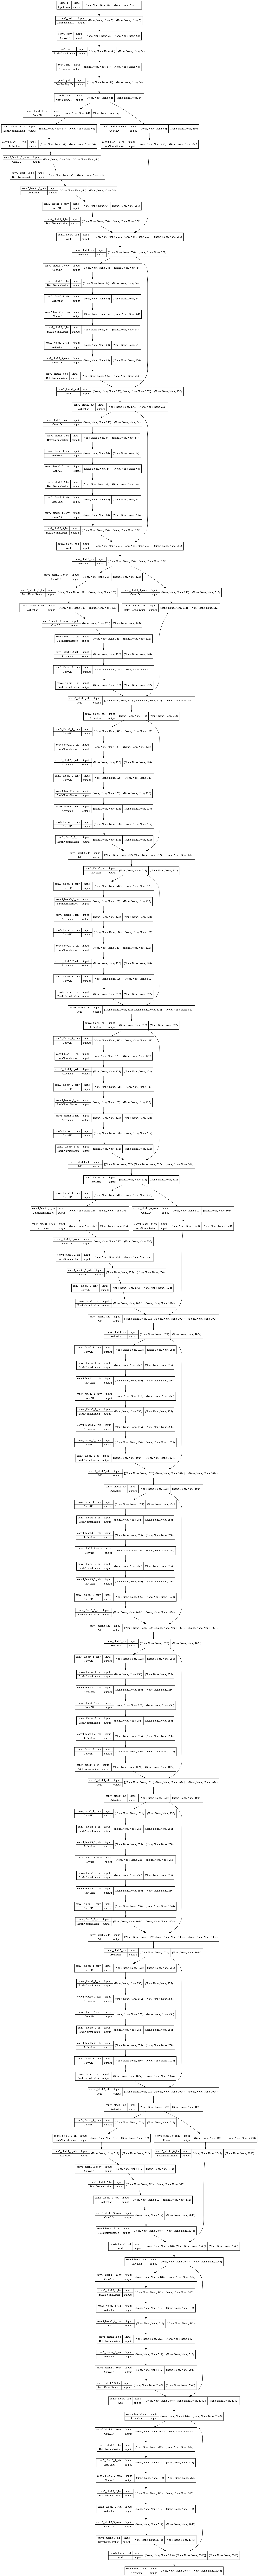

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(base_model, to_file=os.path.join(WORKING_DIR,'model_plot.png'), show_shapes=True, show_layer_names=True)

## Replace classification layer

Here we add the final classification layers back to the network.

In [7]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout


CLASSES = 5
# These layers were removed by setting include_top=false, but we still want them
x = base_model.output                          # The output layer of the googleNet
x = GlobalAveragePooling2D(name='avg_pool')(x) # This layer is used to downsample the features
x = Dropout(0.4)(x)                            # This layer is used to enforce feature redundancy 

# This layer specifies our classifier output
predictions = Dense(CLASSES, activation='softmax')(x)
#
model = Model(inputs=base_model.input, outputs=predictions)



We only want to train the final layers of the network, so we set this flag to ensure that the pre-trained layers stay as they were.

In [8]:
for layer in base_model.layers:
    layer.trainable = False # Set this to True if you want to re-train the entire network.

Finally we compile our Model

In [9]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Train the network

In [10]:
EPOCHS = 30
BATCH_SIZE = 11
STEPS_PER_EPOCH = 5
VALIDATION_STEPS = 1
MODEL_FILE = os.path.join(WORKING_DIR,'model')

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/30
5/5 [==============================] - 17s 601ms/step - loss: 2.3277 - accuracy: 0.2000 - val_loss: 1.5616 - val_accuracy: 0.1818
Epoch 2/30
5/5 [==============================] - 2s 362ms/step - loss: 1.8836 - accuracy: 0.1273 - val_loss: 1.5642 - val_accuracy: 0.2727
Epoch 3/30
5/5 [==============================] - 2s 370ms/step - loss: 1.8375 - accuracy: 0.1636 - val_loss: 1.4981 - val_accuracy: 0.4545
Epoch 4/30
5/5 [==============================] - 2s 368ms/step - loss: 1.8093 - accuracy: 0.2000 - val_loss: 1.5696 - val_accuracy: 0.1818
Epoch 5/30
5/5 [==============================] - 2s 364ms/step - loss: 1.7470 - accuracy: 0.2545 - val_loss: 1.6445 - val_accuracy: 0.0000e+00
Epoch 6/30
5/5 [==============================] - 2s 365ms/step - loss: 1.7032 - accuracy: 0.2727 - val_loss: 1.6111 - val_accuracy: 0.1818
Epoch 7/30
5/5 [==============================] - 2s 368ms/step - loss: 1.8091 - accuracy: 0.2182 - val_loss: 1.4949 - val_accuracy: 0.6364
Epoch 8/30
5/5 

Now lets visualize how accuracy and loss changed with each epoch.


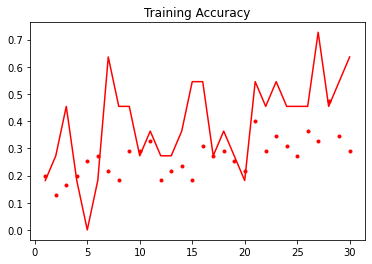

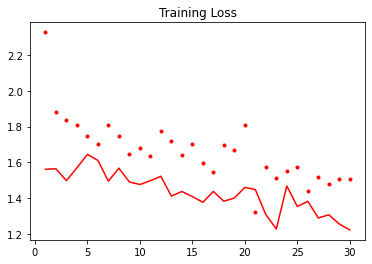

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()

## Test Trained Network

Finally, we can see how our trained network does classifying a new image. 

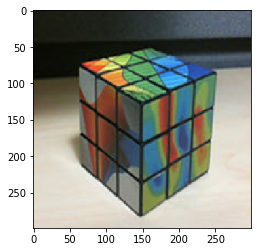

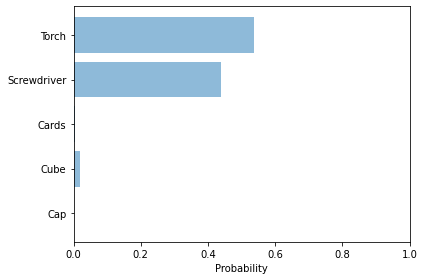

In [15]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

# Predict pre-processes the input so that it matches the format expected by the 
# network, then runs model.predict which provides the class predictions
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

# We plot the original image
plt.figure()
img = image.load_img('MerchDataTest.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(load_model(MODEL_FILE), img)
plt.imshow(img)

# We can visualize the predicted likelihood of each class
plt.figure()
labels = ["Cap", "Cube","Cards","Screwdriver","Torch"]
plt.barh(range(5),preds,alpha=0.5)
plt.yticks(range(5),labels)
plt.xlabel('Probability')
plt.xlim(0,1)
plt.tight_layout()
plt.show()

For a more in-depth tutorial on transfer learning, [click here](https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5)

